# Time Series Forecasting with ARIMA

Time series forecasting is a powerful technique used in many domains to predict future values based on previously observed data points. One of the classic datasets for such problems is the **Airline Passenger Dataset**, which records the monthly number of international airline passengers from 1949 to 1960. This dataset is widely used to demonstrate time series modeling because of its clear trend and seasonal patterns.

###  Objective

The goal of this project is to build accurate forecasting models using:

* **ARIMA (AutoRegressive Integrated Moving Average)**
* **SARIMA (Seasonal ARIMA)**

We will analyze the dataset, transform it appropriately, and evaluate how well each model performs in capturing the underlying structure of the data and making future predictions.

##  What is Time Series?

A time series is a sequence of data points collected or recorded at specific time intervals (e.g., hourly, daily, monthly). Unlike other types of data, time series data is ordered, and temporal ordering is crucial for modeling.

Key characteristics of time series:

* Trend: Long-term increase or decrease in the data.
* Seasonality: Regular and predictable pattern repeating over time (e.g., monthly sales).
* Noise: Random variation in the data.

##  Introduction to ARIMA Models


The **ARIMA** model stands for:

* **AR (AutoRegressive)**: Regression of the variable on its own lagged (past) values.
* **I (Integrated)**: Differencing of raw observations to make the time series stationary.
* **MA (Moving Average)**: Modeling the error as a linear combination of error terms from the past.

**ARIMA(p, d, q)** parameters:

* **p** = order of autoregression (AR)
* **d** = number of differences needed to make the series stationary (I)
* **q** = order of moving average (MA)

### ARIMA Formula

Let $y_t$ be the time series at time $t$:

$$
y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \theta_1 \varepsilon_{t-1} + \theta_2 \varepsilon_{t-2} + \ldots + \theta_q \varepsilon_{t-q} + \varepsilon_t
$$

Where:

* $\phi_i$ = AR coefficients
* $\theta_j$ = MA coefficients
* $\varepsilon_t$ = white noise error term
* $c$ = constant term

### SARIMA Definition

The **SARIMA** model (Seasonal ARIMA) extends ARIMA to support seasonal components. It is defined as:

**SARIMA(p, d, q)(P, D, Q, s)**

Where:

* $p, d, q$: Non-seasonal ARIMA parameters
* $P, D, Q$: Seasonal autoregressive, differencing, and moving average terms
* $s$: Length of the seasonal cycle (e.g., 12 for monthly data with yearly seasonality)


* **ARIMA** is suitable when the dataset shows trend but no seasonality.
* **SARIMA** is ideal when the dataset exhibits both trend and seasonal patterns.

## Loading the dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime


from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_absolute_error,mean_squared_error
from pandas.tseries.offsets import DateOffset
plt.rc("figure",figsize=(12,4))

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv(
    'AirPassengers.csv',
    parse_dates=[0],
    index_col=[0],
    names=['Date','Passengers'],
    header=0)
data.head()

,Passengers
Date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
data.describe()

,Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


<Axes: xlabel='Date'>

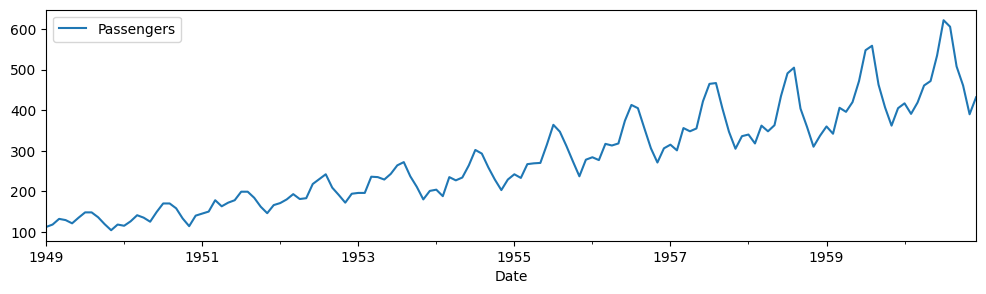

In [5]:
data.plot(figsize=(12,3))


### Components of Time Series :

A Time Series consists of the following components :

- Trend : Long term direction of the data. E.g : Year on year rising temperature of the Earth due to Global Warming.

- Seasonality : Short term repetitve patterns of the data due to the weather seasons. E.g : Sale of sweaters specifically in the winter season.

- Cyclic Variations : Short term repetitive patterns of the data over a period of 1 year. E.g : It usually consists of the Business Quarters i.e Q1, Q2, Q3 & Q4.

- Irregularities : Random and unforseen fluctuations in the data. E.g : Occurrences of Earthquakes or Floods, etc.

In order to assess a Time Series, we need to consider the above components and make sure that our data is free from all these components in order to make a forecast.

Let's visualize the Passengers data for the above components!

For this purpose, we use  the statsmodel library.

- Additive Model : Data has same width and height of the seasonal patterns or peaks. Trend of the data is linear.
- Multiplicative Model : Data has increasing / decreasing width and height of the seasonal patterns or peaks. Trend of the data is non-linear.

In [6]:
timeseries = data

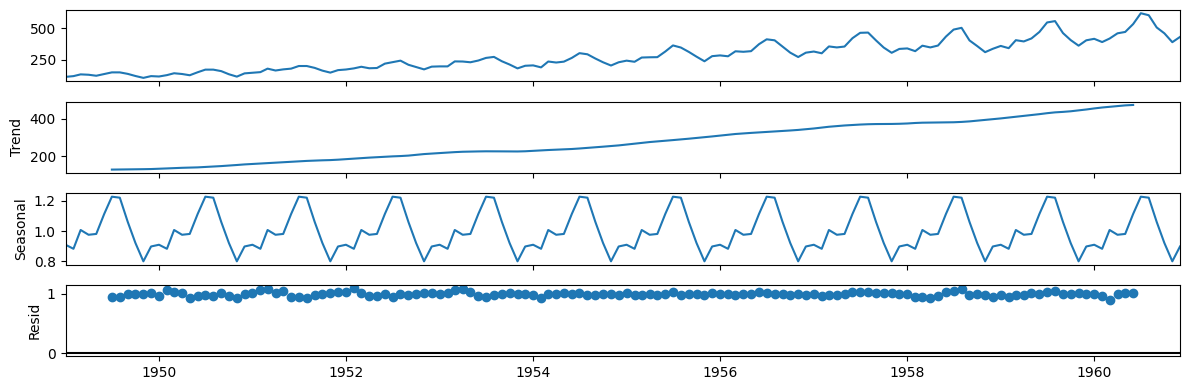

In [7]:

seasonal_decompose(timeseries,period = 12, model = 'multiplicative').plot();

The Airline Passenger dataset clearly shows both a rising trend and yearly seasonality, making **SARIMA** especially well-suited.

### Stationarity

Stationarity is a concept for time series where statistical parameters like mean, variance, etc are all constant over time.
For a time series, features are  a function of time. Statistical paramters will change values over time as they are extracted from the features.
If the time series is not stationary, then the predictions deviate from the original values and increase the error as we don't know the changes in these statistical parameters as they are a function of time.
Thus, by making time series stationary, we kind of nullify the effects of statistical parameters on the forecast.

To test stationarity, we will use **Augmented Dickey Fuller Test** :

- Null Hypothesis : It assumes that the time series is non-stationary.
- Alternate Hypothesis : If the null hypothesis is rejected, then the time series is stationary.


For the Null Hypothesis to be rejected and accepting that the time series is stationary, there are 2 requirements :
- Critical Value (5%) > Test Statistic
- p-value < 0.05

In [8]:
# test stationarity

def test_stationarity(timeseries):
  rollingMean = timeseries.rolling(window=12).mean()
  rollingStd = timeseries.rolling(window=12).std()

  plt.figure(figsize=(12,4))

  plt.plot(timeseries, color='blue', label='Original')
  plt.plot(rollingMean, color='red', label='Rolling Mean')
  plt.plot(rollingStd, color='black', label='Rolling Std')
  plt.legend(loc='best')


  dftest = adfuller(timeseries, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
  for key,value in dftest[4].items():
      dfoutput[f'Critical Value {key}'] = value
  display(dfoutput)

,0
Test Statistic,0.815369
p-value,0.991880
#Lags Used,13.000000
Number of Observations Used,130.000000
Critical Value 1%,-3.481682
Critical Value 5%,-2.884042
Critical Value 10%,-2.578770


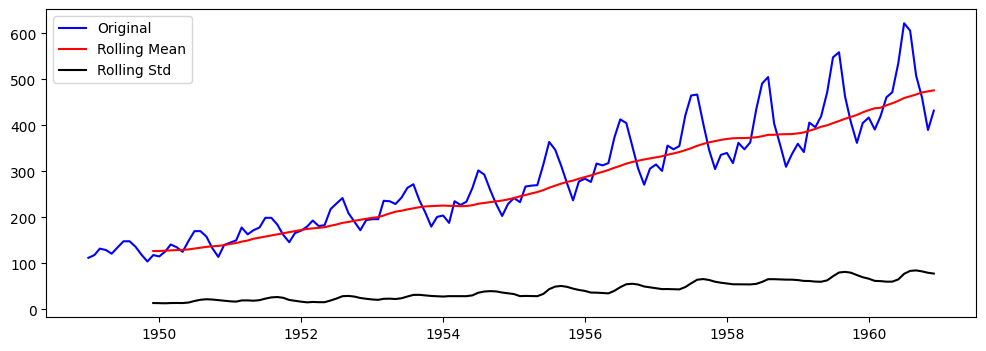

In [9]:
test_stationarity(timeseries)

For the Passengers time series data:

- Rolling Mean is clearly variable with time.
- Rolling Standard Deviation is has some crests - troughs that vary according to the time.
- Test Statistic : (0.82) > Critical Value (5%) : (-2.88)
- p-value (0.99) > 0.05

Hence, Null Hypothesis cannot be rejected and we can conclude that the above Passengers time series is not stationary.

In order to eliminate trend, seasonality and make the time series stationary, we will use differencing i.e subtracting the previous value from it's next value. We will work on log values of the data from here!

### First differencing of time series

In [11]:
data_diff = data.diff()
data_diff = data_diff.dropna()

timeseries = data_diff['Passengers']

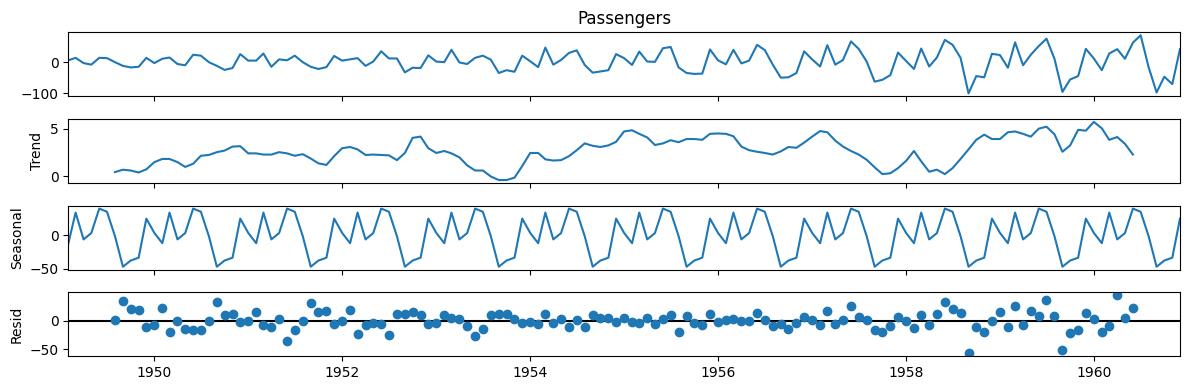

In [12]:
seasonal_decompose(timeseries,period = 12).plot();

,0
Test Statistic,-2.829267
p-value,0.054213
#Lags Used,12.000000
Number of Observations Used,130.000000
Critical Value 1%,-3.481682
Critical Value 5%,-2.884042
Critical Value 10%,-2.578770


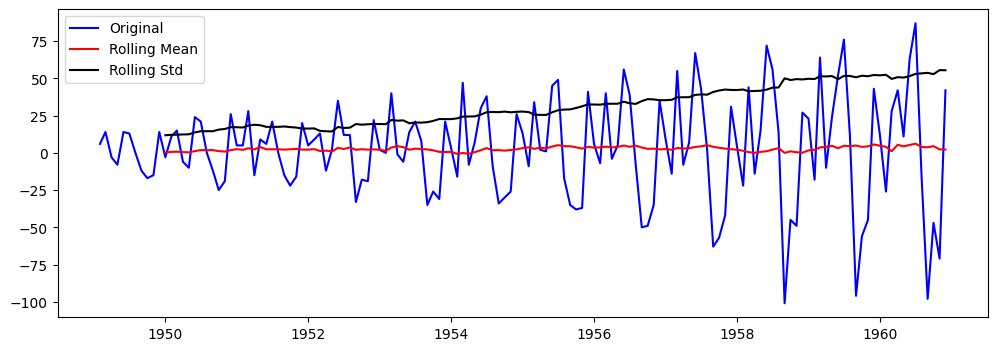

In [13]:
test_stationarity(timeseries)

From the above outcome, the time series again fails the stationarity test. However since the parameters are very close to stationarity and further differencing might degrade the performance, we will use this time data for further model building.

## ARIMA model implementation.



### Find pdq

Selection criteria for the order of ARIMA model :

- p : Lag value where the Partial Autocorrelation (PACF) graph cuts off or drops to 0 for the 1st instance.
- d : Number of times differencing is carried out to make the time series stationary.
- q : Lag value where the Autocorrelation (ACF) graph crosses the upper confidence interval for the 1st instance.

- ACF graph provides the correlation between the time series & it's lags. For the above time series, we can observe a positive lowering correlation.
- PACF graph provides the correlation between the time series and individual lags. These correlation coefficients are unlike the mutual correlations that are calculated in the presence of other features.


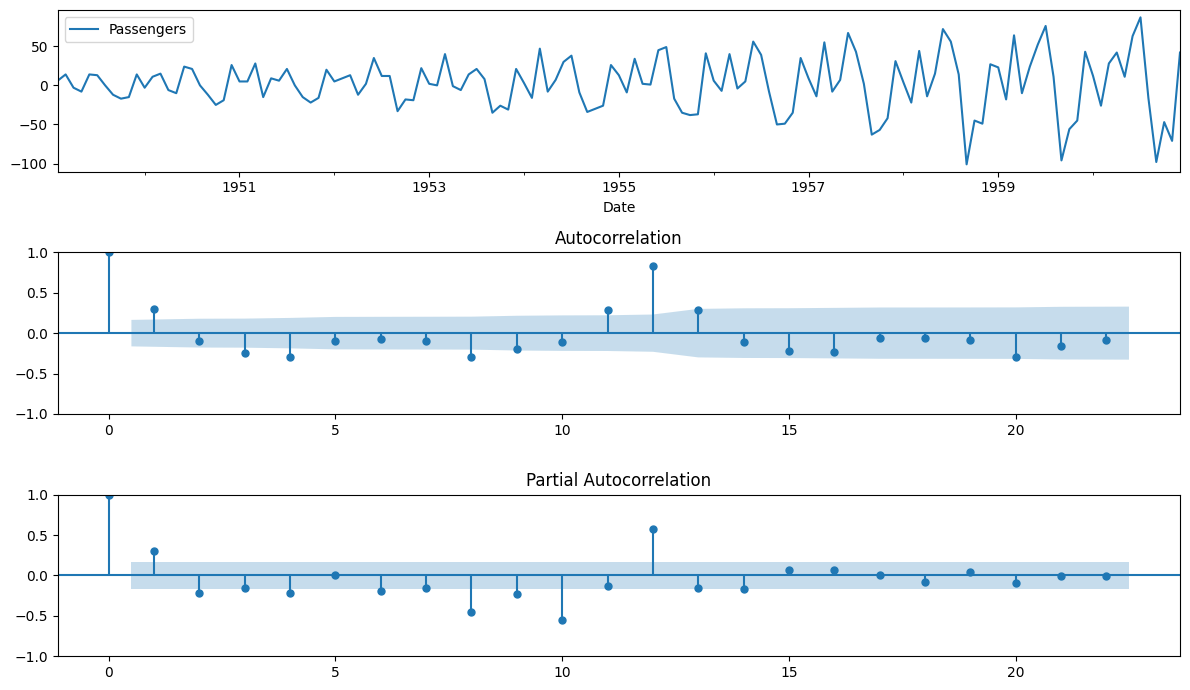

In [17]:
fix,ax = plt.subplots(3,1, figsize=(12,7))


data_diff.plot(ax=ax[0])
plot_acf(data_diff, ax=ax[1], lags=None);
plot_pacf(data_diff, ax=ax[2], lags=None);
plt.tight_layout()


From the above plots, the following order of ARIMA model is selected from the selection criteria mentioned above:

p=2, d=1, q=2

### Model fit


In [18]:
model = ARIMA(data['Passengers'], order=(2,1,2))
model_fit = model.fit()

print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -671.673
Date:                Tue, 03 Jun 2025   AIC                           1353.347
Time:                        04:25:30   BIC                           1368.161
Sample:                    01-01-1949   HQIC                          1359.366
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6850      0.020     83.060      0.000       1.645       1.725
ar.L2         -0.9548      0.017    -55.420      0.000      -0.989      -0.921
ma.L1         -1.8432      0.124    -14.814      0.0

### Forcasting


Lets forcast future values using our model based on the historical data

### In sample forcasting

 Model forecasts values for the existing data points of the time series. It is similar to the train - test format for regression or classification problems.

#### Rolling forcasting


In this style, the model predicts a single points beyond the training data and the model is then retrained on the newly generated data allowing for more accurate and adaptive predictions.

In [25]:
n_periods = 25
size = int(len(data) - n_periods)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]



history = [x for x in train]
predictions = []

for t in range(len(test)):

    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()

    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))

    obs = test[t]
    history.append(obs)

    # print('predicted = %f, expected = %f' % (yhat, obs))


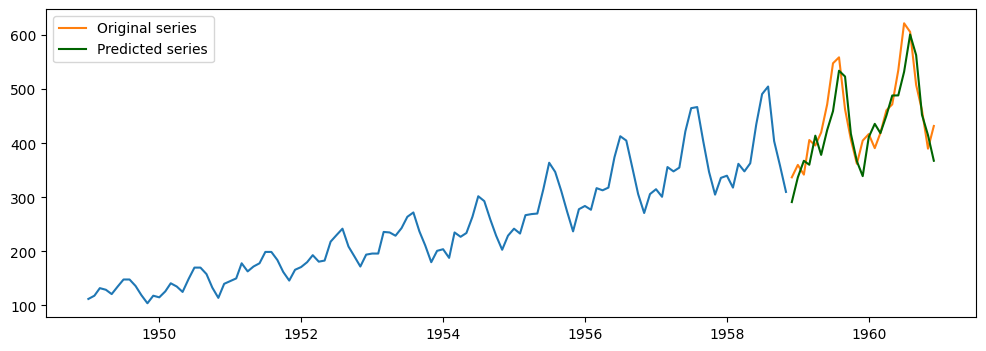

In [36]:
# Plot
plt.plot(train)
plt.plot(test, label='Original series')
plt.plot(pd.Series(predictions, index=test.index), color='darkgreen', label='Predicted series')

plt.legend()
plt.show()

Not a bad prediction.

#### Direct forcasting

In this style we will use the training data to predict all the new future data points at once.

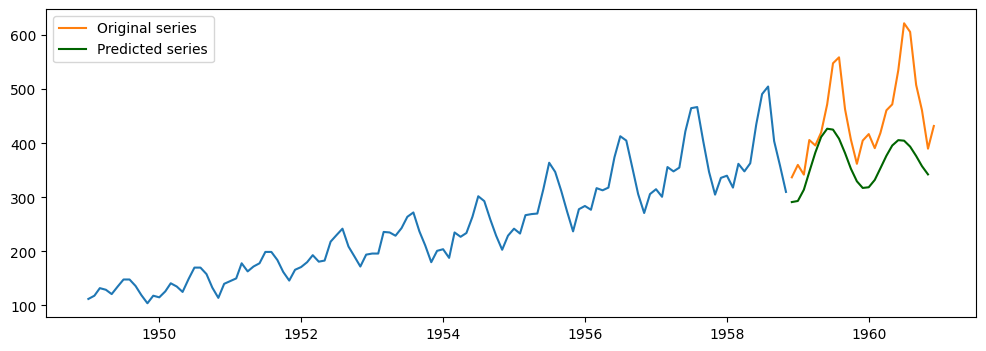

In [32]:
n_periods = 25
size = int(len(data) - n_periods)
train, test = data['Passengers'][0:size], data['Passengers'][size:len(data)]

model = ARIMA(train, order = (2,1,2))
model_fit = model.fit()
# print(model_fit.summary())


# fitted, confint = model_fit.forecast(n_periods, return_conf_int=True)
fitted = model_fit.forecast(n_periods, return_conf_int=True)
index_of_fc = pd.date_range(train.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(train)
plt.plot(test, label='Original series')
plt.plot(fitted_series, color='darkgreen', label='Predicted series')

plt.legend()

plt.show()

### Out of sample forcasting

Now, we will forcast new future values outside the datetime index



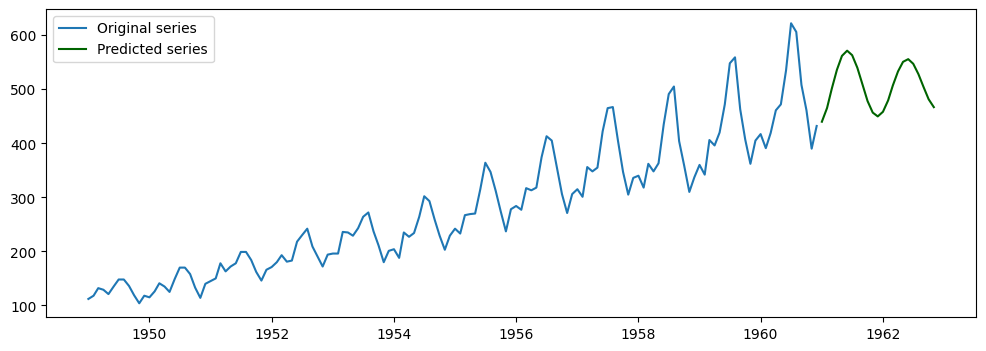

In [39]:
model = ARIMA(data['Passengers'],order = (2,1,2))
model_fit = model.fit()
# print(model_fit.summary())

n_periods = 24
# fitted, confint = model_fit.forecast(n_periods, return_conf_int=True)
fitted = model_fit.forecast(n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data,label='Original series')
# plt.plot(test, label='Original series')
plt.plot(fitted_series, color='darkgreen', label='Predicted series')

plt.legend()

plt.show()

## SARIMA

- The plain ARIMA model has a problem. It does not support seasonality. If the time series has defined seasonality, then we should go for Seasonal ARIMA model (in short SARIMA) which uses seasonal differencing.

- Seasonal differencing is similar to regular differencing, but, instead of subtracting consecutive terms, we subtract the value from previous season.
- The model will be represented as SARIMA(p,d,q)x(P,D,Q), where, P, D and Q are SAR, order of seasonal differencing and SMA terms respectively and 'x' is the frequency of the time series. If the model has well defined seasonal patterns, then enforce D=1 for a given frequency.

### Find PDQ for SARIMA

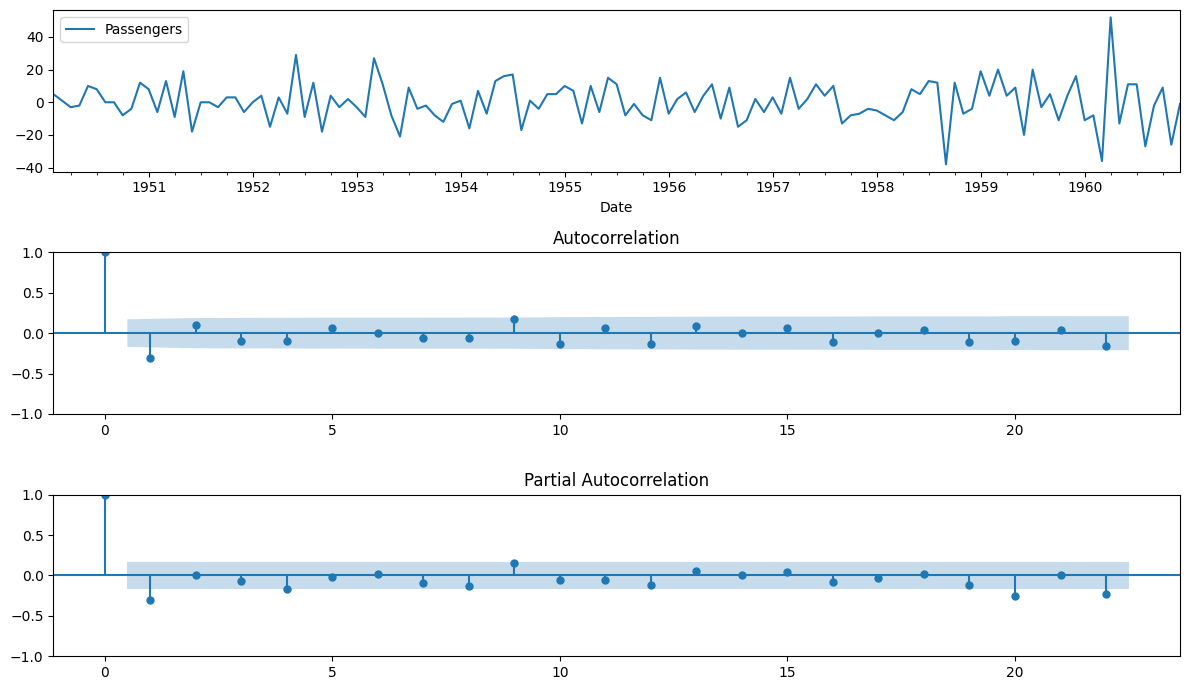

In [51]:
fix,ax = plt.subplots(3,1, figsize=(12,7))

data_diff_s = data_diff.diff(12 ).dropna()

data_diff_s.plot(ax=ax[0])
plot_acf(data_diff_s, ax=ax[1], lags=None)
plot_pacf(data_diff_s, ax=ax[2], lags=None)

plt.tight_layout()

Based on the above plots, we choose the following parameters:

P=1, D=1, Q=1

### Model fit



In [40]:
model = SARIMAX(data['Passengers'],order = (2,1,2),seasonal_order = (1,1,1,12))
model_fit = model.fit()
# print(model_fit.summary())

print(model_fit.summary())


                                      SARIMAX Results                                       
Dep. Variable:                           Passengers   No. Observations:                  144
Model:             SARIMAX(2, 1, 2)x(1, 1, [1], 12)   Log Likelihood                -503.024
Date:                              Tue, 03 Jun 2025   AIC                           1020.048
Time:                                      04:43:02   BIC                           1040.174
Sample:                                  01-01-1949   HQIC                          1028.226
                                       - 12-01-1960                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4441      0.388      1.145      0.252      -0.316       1.204
ar.L2          0.32

### Forcasting




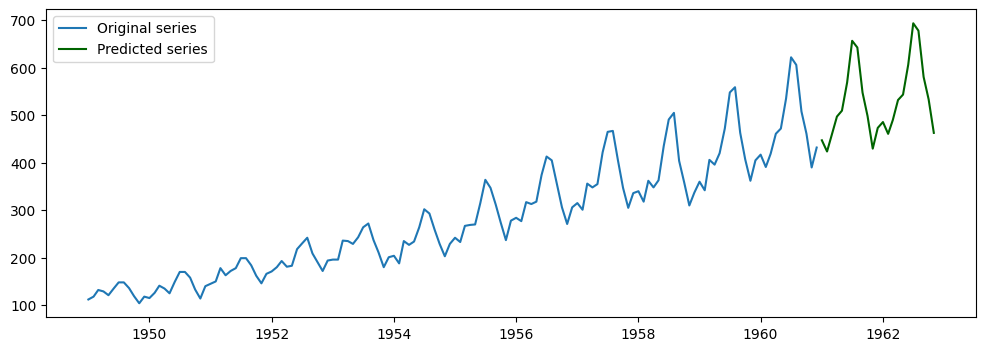

In [52]:

n_periods = 24
# fitted, confint = model_fit.forecast(n_periods, return_conf_int=True)
fitted = model_fit.forecast(n_periods, return_conf_int=True)
index_of_fc = pd.date_range(data.index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
# lower_series = pd.Series(confint[:, 0], index=index_of_fc)
# upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(data,label='Original series')
# plt.plot(test, label='Original series')
plt.plot(fitted_series, color='darkgreen', label='Predicted series')

plt.legend()


plt.show()

Seems like much better forcasting than normal ARIMA